# 2D robot examples

In [1]:
import sys
sys.path.append('lib')

import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict
import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
import os, time
from tf_robot_learning import kinematic as tk

from IPython.core import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

In [3]:
class Robot():
    def __init__(self,l1, l2):
        self.l1 = l1
        self.l2 = l2
        self.theta1 = 0.
        self.theta2 = 0.
        self.obstacles = []
        self.R = np.array([[np.cos(np.pi/2), -np.sin(np.pi/2)],[np.sin(np.pi/2), np.cos(np.pi/2)]])
        
    def set_dof(self,theta):
        self.theta1 = theta[0]
        self.theta2 = theta[1]
        
    def rotate90(self,vec):
        return np.dot(self.R, vec)
    
    def add_obstacle(self, x, y, r):
        obstacle = dict()
        obstacle['rad'] = r
        obstacle['pos'] = np.array([x,y])
        self.obstacles += [obstacle]
        
    def check_collision_single(self, obstacle):    
        c = obstacle['pos'][:,None]
        r = obstacle['rad']
        b1 = c - self.p0
        b2 = c - self.p1
        self.res1 = np.linalg.solve(self.A1,b1)
        self.res2 = np.linalg.solve(self.A2,b2)
        if self.res1[0] >= 0. and self.res1[0] <= 1.:
            if np.abs(self.res1[1]) <= r:
                return True
        else:
            if np.linalg.norm(self.p0-c) < r or np.linalg.norm(self.p1-c) < r:
                return True
        
        if self.res2[0] >= 0. and self.res2[0] <= 1.:
            if np.abs(self.res2[1]) <= r:
                return True
        else:
            if np.linalg.norm(self.p1-c) < r or np.linalg.norm(self.p2-c) < r:
                return True
            
        return False
        
        
    def normalize(self,vec):
        return vec/np.linalg.norm(vec)
        
    def check_collision(self):
        self.p0 = np.array([0.,0.])[:,None]
        self.p1 = np.array([self.l1*np.cos(self.theta1),self.l1*np.sin(self.theta1)])[:,None]
        self.p2 = np.array([self.p1[0,0] + self.l2*np.cos(self.theta1+self.theta2),self.p1[1,0] + self.l2*np.sin(self.theta1+self.theta2)])[:,None]
        self.v1 = self.normalize(self.rotate90(self.p1-self.p0))
        self.v2 = self.normalize(self.rotate90(self.p2-self.p1))
        self.A1 = np.hstack([self.p1-self.p0, -self.v1])
        self.A2 = np.hstack([self.p2-self.p1, -self.v2])
        
        for obstacle in self.obstacles:
            if self.check_collision_single(obstacle):
                return True
            
        return False
        
        
        
    def plot(self):
        x = [0., self.l1*np.cos(self.theta1), self.l1*np.cos(self.theta1) + self.l2*np.cos(self.theta1+ self.theta2)]
        y = [0., self.l1*np.sin(self.theta1), self.l1*np.sin(self.theta1) + self.l2*np.sin(self.theta1+ self.theta2)]
        fig, ax = plt.subplots(nrows = 1, figsize = (6,6))
        plt.plot(x,y,'b',linewidth=5)
        plt.plot(x[:-1],y[:-1],'oy',markersize=3 )
        for obstacle in self.obstacles:
            r = obstacle['rad']
            p = obstacle['pos']
            circle = plt.Circle(p, r, color='r')
            ax.add_artist(circle)
            
        #add base
        rect = patches.Rectangle((-0.35,-0.35),0.7,0.7,linewidth=1,edgecolor='g',facecolor='g')
        ax.add_patch(rect)
        ax.set_xlim([-6,6])
        ax.set_ylim([-6,6])
        #ax.axis('equal')
        ax.set(xlim=(-2*self.l1-2*self.l2,2*self.l1+2*self.l2), ylim=( -2*self.l1-2*self.l2,2*self.l1+2*self.l2))
        return ax
        
    def sample_state(self, N=1):
        samples = []
        samples_status = []
        for i in range(N):
            sample = np.random.rand(2)*np.pi*2
            self.set_dof(sample)
            sample_status = self.check_collision()
            samples.append(sample)
            samples_status.append(sample_status)
    
        return np.array(samples), np.array(samples_status)

In [4]:
import matplotlib.patches as patches

## Load Data

In [5]:
f = open('data/2dparams.npy','rb')
params = np.load(f,allow_pickle=True).tolist()
f.close()

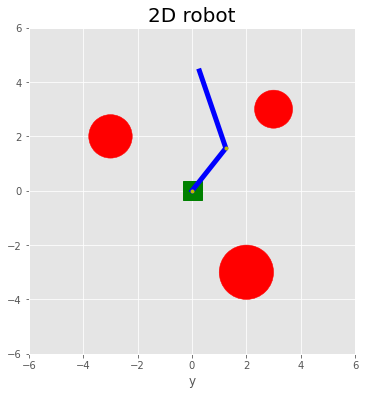

In [6]:
rob = Robot(params['lengths'][0],params['lengths'][1])
for obs in params['obstacles'][:3]:
    rob.add_obstacle( obs['pos'][0], obs['pos'][1],obs['rad'])

rob.set_dof([0.9,1.])
ax = rob.plot()
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_aspect('equal')
ax.set_title('2D robot', fontsize = 20)
plt.savefig('data/2drobot.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [7]:
samples, status = rob.sample_state(100000)

In [8]:
samples_valid = samples[np.logical_not(status)]
print(samples_valid.shape)

(86159, 2)


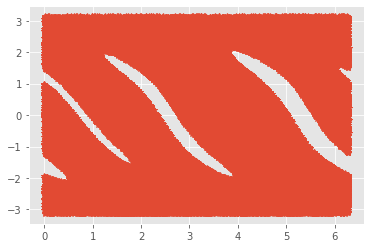

In [14]:
plt.plot(samples_valid[:,0], samples_valid[:,1], '*')

In [12]:
idx = samples_valid[:,1] > np.pi

In [13]:
samples_valid[idx,1] -= np.pi*2

In [15]:
np.save('data/2dsamples_new4.npy', samples_valid)

In [122]:
f = open('data/2dsamples_new.npy','rb')
data = np.load(f, allow_pickle=True)

### Load kinematic chain 

In [123]:
from tf_robot_learning import planar_robots

In [124]:
robot = planar_robots.TwoJointRobot(ls=np.array(params['lengths']))

## Create Data

In [125]:
fs = [
    lambda q : robot.xs(q)[:, -1],
]

In [126]:
q_eval = tf1.placeholder(tf.float32, (None,robot.dof))
x_eval = robot.xs(q_eval)

def q_augmented(q):
    # return tf.concat([q, fs[0](q)], axis=1)
    return tf.concat([q, tf.sin(q), tf.cos(q)], axis=1)

q_augmented_eval = q_augmented(q_eval)
q_target_eval = fs[0](q_eval)

In [127]:
data_augmented = q_augmented_eval.eval({q_eval: data})
data_target = q_target_eval.eval({q_eval: data})

In [128]:
def get_batch(_batch_size=30, cut=None, augmented=True):
    if cut is not None:    
        idx = np.random.randint(
            0, cut, _batch_size)
    else:
        idx = np.random.randint(
            0, data_augmented.shape[0]-1, _batch_size)
    if augmented: return data_augmented[idx]
    else: return data[idx]
    
def get_target_batch(_batch_size=30, cut=None):
    if cut is not None: idx = np.random.randint( 0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    return data_target[idx]


## Model 

In [129]:
# Parameters
rate = tf1.placeholder(tf.float32, ())

# Network Parameters
joint_dim = robot.dof # MNIST images are 28x28 pixels
latent_dim = 6

target_dim = 2
#target_latent_dim = 2

augmented_dim = data_augmented.shape[-1]

N_net = 1

In [130]:
gen_nn = rl.nn.MLP(
    n_input=latent_dim+target_dim, n_output=joint_dim, n_hidden=[200, 200],
    act_fct=tf.nn.relu, batch_size_svi=N_net
)

In [131]:
discr_nn = rl.nn.MLP(
    n_input=augmented_dim, n_output=1, n_hidden=[100, 100],
    act_fct=tf.nn.relu
)

In [132]:
batch_x = tf1.placeholder(tf.float32, (None, augmented_dim))

In [133]:
# target parameters to feed generator
batch_target = tf1.placeholder(tf.float32, (None, target_dim))

In [134]:
batch_size = tf1.placeholder(tf.int32, ())

In [135]:
# Sampler: Normal (gaussian) random distribution
# eps = tf.random.normal([batch_size, latent_dim], 
    # dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
eps = tf.random.normal([tf.cast(batch_size/N_net, tf.int32), latent_dim], 
    dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')

In [136]:
# to feed main generator noise + parameters samples
eps_conc = tf.concat([eps, batch_target], axis=-1)

In [137]:
tf.reshape(gen_nn.pred(eps_conc), (-1, joint_dim))

<tf.Tensor 'Reshape_49:0' shape=(None, 2) dtype=float32>

In [139]:
# samples_q = gen_nn.pred(eps_conc) + tf.constant([4., 4.])[None]
samples_q = tf.reshape(gen_nn.pred(eps_conc) + tf.constant(
    np.random.normal(3., 3., (N_net, 1, 2)), dtype=tf.float32) , (-1, joint_dim)) 
samples_x = robot.xs(samples_q)

### Another evaluation to feed custom noise 

In [140]:
d_fake = discr_nn.pred(q_augmented(samples_q))[:, 0]
d_true = discr_nn.pred(batch_x)[:, 0]

#### Discriminative loss

#### Generative loss

In [142]:
loss_d = tf.reduce_mean(d_fake) - tf.reduce_mean(d_true)
loss = -tf.reduce_mean(d_fake)

### Target loss 

In [143]:
# define a Gaussian distribution that should be tracked by the system
p_target_std = tf1.placeholder(tf.float32, ()) 
p_target = ds.MultivariateNormalFullCovariance(
    # batch_target, p_target_std**2 * tf.eye(2)
    tf.reshape(tf.ones((N_net, 1, 1)) * batch_target[None], (-1, target_dim)), p_target_std**2 * tf.eye(2)
)
samples_target_proj = fs[0](samples_q)

In [144]:
loss_target = tf.reduce_sum(-p_target.log_prob(samples_target_proj))
# loss_target = tf.reduce_sum(tf.norm(batch_target-samples_target_proj,axis=1))
lmbda_target = tf1.placeholder(tf.float32, ())

#### Overall loss 

In [145]:
loss_gen = loss + lmbda_target * loss_target

In [146]:
clip_value = 0.01

In [147]:
#nn_gen_weights =         gen_nn.vec_weights.assign(tf.clip_by_value(gen_nn.vec_weights, clip_value_min=-clip_value, clip_value_max=clip_value))
nn_disc_weights =        discr_nn.vec_weights.assign(tf.clip_by_value(discr_nn.vec_weights, clip_value_min=-clip_value, clip_value_max=clip_value))


### Optimizers 

In [148]:
rate = tf1.placeholder(tf.float32, ())
opt = tf1.train.RMSPropOptimizer
#opt = tf1.train.AdamOptimizer


optimizer = opt(learning_rate=rate)
optimizer_d = opt(learning_rate=rate)

train = optimizer.minimize(loss_gen, var_list=gen_nn.vec_weights)
train_d = optimizer_d.minimize(loss_d, var_list=discr_nn.vec_weights)

# Initialize the variables (i.e. assign their default value)
init = tf1.global_variables_initializer()

In [149]:
sess.run(init)

In [188]:
_batch_size = 32
alpha = 0.005
alpha = 0.005

for i in range(100000):
    try:
        for j in range(5):
            # train discriminative_network
            _x = get_batch( _batch_size=_batch_size)
            feed_dict = {
                lmbda_target: 0.5,
                p_target_std: 1.,
                batch_x: _x,
                batch_size: _batch_size,
                rate : 0.002 * alpha
            }
            feed_dict[batch_target] = get_target_batch( _batch_size=int(_batch_size/N_net))
            #_ = sess.run([train_d, nn_disc_weights], feed_dict=feed_dict)
            _ = sess.run([train_d], feed_dict=feed_dict)
            
        feed_dict[rate] = 0.001 * alpha
        # train generative_network
        _, _loss, _loss_target, _loss_d  = sess.run(
           [train, loss, loss_target, loss_d], feed_dict=feed_dict)
        
        if not i % 10:
            display.clear_output(wait=True)
            print('Step %i\t, Loss gen: %f\t, loss discr %f, loss target %f' % (i, _loss, _loss_d, _loss_target))
    except KeyboardInterrupt:
        break

Step 99990	, Loss gen: 1533.850342	, loss discr -2.521851, loss target 166.794220


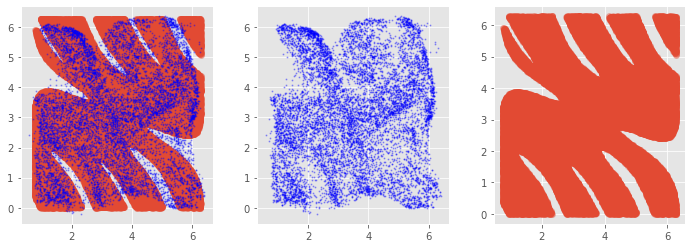

In [191]:
n = 10000
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,4)
_targets = get_target_batch(cut=3000, _batch_size=int(n/N_net))

# _samples_q = samples_q.eval({batch_size: n, batch_target: _targets})
_samples_q = samples_q.eval({batch_size: n, batch_target: _targets})
# _samples_xs = sess.run(x_eval, {q_eval: _samples_q})

#plt.plot(samples_invalid[:,0],samples_invalid[:,1], 'oy')

ax[0].plot(data[:,0],data[:,1],'o',alpha=0.3)
ax[0].plot(_samples_q[:,0],_samples_q[:,1],'bo',alpha=0.3, markerSize=1)
ax[1].plot(_samples_q[:,0],_samples_q[:,1],'bo',alpha=0.3, markerSize=1)
ax[2].plot(data[:,0],data[:,1],'o',alpha=0.3)

for a in ax:
    a.set_aspect('equal')

In [ ]:
np.save('2d_'+str(N_net)+'.npy', data)

In [ ]:
data = np.load('2d_'+str(N_net)+'.npy')

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize = (6,6))
ax.plot(data[:,0],data[:,1],'o',alpha=0.3)
ax.plot(_samples_q[:,0],_samples_q[:,1],'bx',alpha=0.3)
ax.set_aspect('equal')
ax.set_xlabel(r'$\bf{\theta_1}$', fontsize=20)
ax.set_ylabel(r'$\bf{\theta_2}$', fontsize=20)
ax.set_xlim([0,6.6])
ax.set_ylim([0,6.6])
ax.set_title(r'$N_{net}$ = ' + str(N_net), fontsize=20)
plt.savefig('data/2d_' + str(N_net) + '.png', bbox_inches='tight', pad_inches=0)
